In [222]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

### Read data and data preprocess

In [223]:
temp=[]
train_data=pd.DataFrame()
for i in range(50):
    path='training_data/target{}.csv'.format(i)
    x = pd.read_csv(path)
    x = x.drop('time', axis=1)
    temp.append(x)
    if i == 0:
        train_data = x
    else:
        train_data += x

# train_data = pd.concat(temp,ignore_index=True)
train_data/=50
normalized_data=train_data.apply(lambda x:(x-x.mean())/ x.std())
generation_mean, generation_std = train_data.mean()[0], train_data.std()[0] 
consumption_mean, consumption_std = train_data.mean()[1], train_data.std()[1]

# train_data['consumption'][:100].plot(kind='bar')
# normalized_data['generation'][:100].plot(kind='bar')

# train_data=preprocessing.MinMaxScaler().fit_transform(train_data)

# print(train_data['generation'].shape)
# print(train_data[0:24][])

In [224]:
def get_data(df, days_to_train=7, days_to_pred=1):
    # 用前7天預測當天
    # X is data, Y is label
    X=[]
    Y=[]
    t=[]
    
    for i in range(df.shape[0]//24):
        t.append(np.array(df.iloc[24*i:24*(i+1)],dtype=np.float32))

    for i in range(len(t)-days_to_train):
        X.append(t[i:(i+days_to_train)])
        Y.append(t[i+days_to_train])

    return np.array(X), np.array(Y)
    
class DataSet(Dataset):

    def __init__(self, a, b, trans):
        self.train=a
        self.valid=b
        self.transform=trans

    def __getitem__(self, index) :
        x=self.train[index]
        y=self.valid[index]

        x=self.transform(x)
        # y=self.transform(y)

        return x, y

    def __len__(self):
        return len(self.train)

In [225]:
X, Y=get_data(normalized_data['generation'])
# print(X.shape)
# print(Y[0])

# generation_x, generation_y=G_X[:int(len(G_X)*0.8)], G_Y[:int(len(G_Y)*0.8)]
# generation_valid_x, generation_valid_y=G_X[int(len(G_X)*0.8):], G_Y[int(len(G_Y)*0.8):]

train_x, train_y=X[:int(len(X)*0.8)], Y[:int(len(Y)*0.8)]
valid_x, valid_y=X[int(len(X)*0.8):], Y[int(len(Y)*0.8):]

transform=transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=train_data.mean()[0],std=train_data.std()[0]),
])
train_loader=DataLoader(dataset=DataSet(train_x, train_y, transform),batch_size=3,shuffle=True)
valid_loader=DataLoader(dataset=DataSet(valid_x, valid_y, transform),batch_size=3,shuffle=True)

### LSTM model

In [226]:
class LSTM(torch.nn.Module):
    def __init__(self, input=24, hidden_size=24, output=24):
        # Input of LSTM : batch, sequence_len, input_size
        super(LSTM, self).__init__()

        self.rnn=torch.nn.LSTM(input, hidden_size, num_layers=1, batch_first=True)
        self.linear=torch.nn.Linear(hidden_size, output)

    def forward(self,x):
        out, (hidden, cell) = self.rnn(x)
        a, b, c = hidden.shape
        # print(hidden.reshape(a*b,c).shape)
        # out = self.linear(hidden.reshape(a*b,c))
        out = self.linear(out[:, -1, :])
        
        return out

# LSTM=torch.nn.LSTM(24,32,batch_first=True)

### Training parameter

In [227]:
EPOCH = 100
LR = 0.01

device = 'cpu'
if torch.cuda.is_available(): # 若想使用 cuda 且可以使用 cuda
    device = 'cuda'

print('Using %s'%device)

Using cuda


### Training function

In [228]:
# Training function
def train(model, epoch, train_loader, valid_loader, type, scheduler):
    preds = []
    targets = []
    smallest_loss = 100
    train_losses = []
    valid_losses = []

    for i in tqdm(range(epoch)):
        # print('============EPOCH {}============'.format(i+1))

        model.train()
        train_loss = 0
        n_of_train_loss = 0
        for _, (data, label) in enumerate(train_loader):
            data, label = data.to(device), label.to(device)

            optimizer.zero_grad()
            pred = model(data.squeeze())
            label = label.unsqueeze(1)
            # print(data.shape)
            # print(pred.shape)
            # break
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            n_of_train_loss += 1
            # print(label.unsqueeze(1).shape)
            # print(pred.shape)
            # break

        # Validate model
        model.eval()
        valid_loss = 0
        n_of_valid_loss = 0

        with torch.no_grad():
            for _, (data, label) in enumerate(valid_loader):
                data, label = data.to(device), label.to(device)

                pred = model(data.squeeze())
                # print(data.shape)
                label = label.unsqueeze(1)

                loss = criterion(pred, label)

                valid_loss += loss.item()
                n_of_valid_loss += 1

                preds.extend(pred.squeeze().tolist())
                targets.extend(label.squeeze().tolist())
                # break

            # print("Train loss:{}".format(train_loss/n_of_train_loss), end=' ')
            # print("Valid loss:{}".format(valid_loss/n_of_valid_loss))
            train_losses.append(train_loss/n_of_train_loss)
            valid_losses.append(valid_loss/n_of_valid_loss)

            if valid_loss/n_of_valid_loss < smallest_loss:
                smallest_loss = valid_loss/n_of_valid_loss
                torch.save(model,'{}.pt'.format(type))

        scheduler.step()

    # torch.save(model,'LSTM.pt')
    print('Smallest loss:', smallest_loss)

    return train_losses, valid_losses, preds, targets


### Training generation model

In [230]:
model = LSTM()
model=model.to(device)
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr = LR)
lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.5)


train_losses, valid_losses, preds, targets=train(model, EPOCH, train_loader, valid_loader, 'Generation', lr_scheduler)
# print(model)

 18%|█▊        | 18/100 [00:04<00:19,  4.15it/s]


KeyboardInterrupt: 

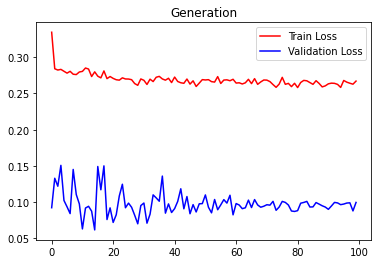

In [ ]:
plt.plot(train_losses, 'r', label='Train Loss')
plt.plot(valid_losses, 'b', label='Validation Loss')
plt.legend()
plt.title('Generation')
plt.show()

# print(len(preds))
# print(len(targets))

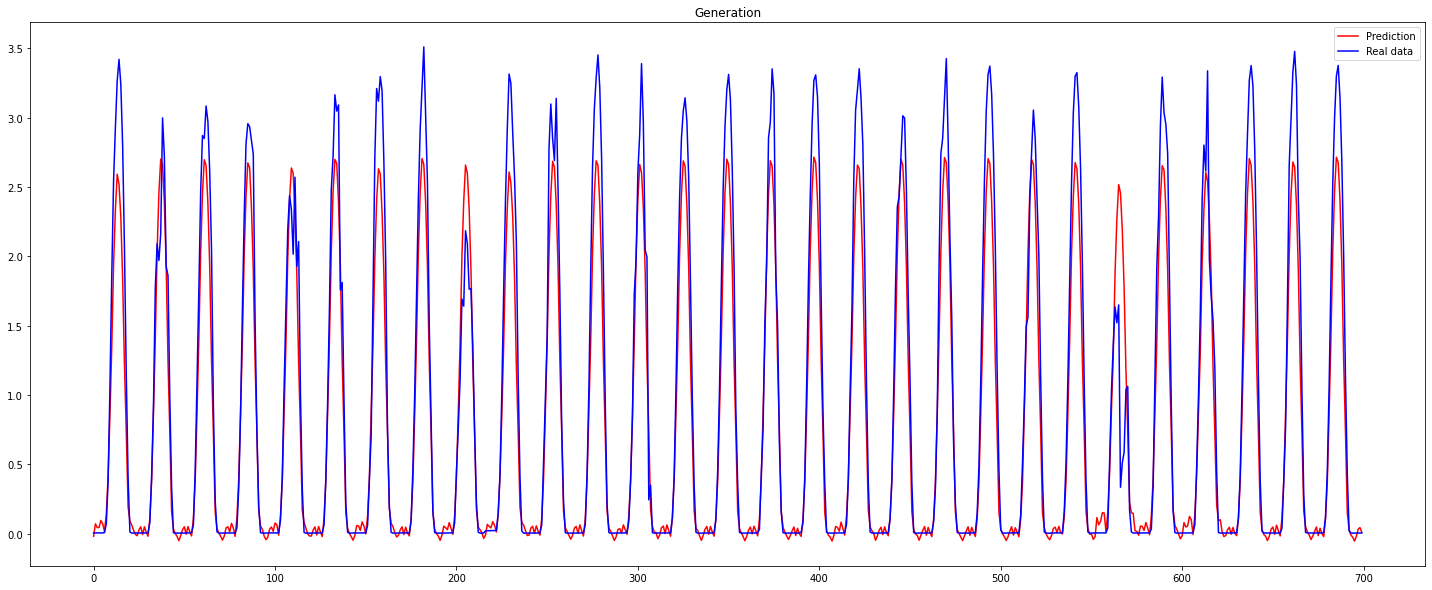

In [ ]:
p, t=[], []
for i in range(len(preds)):
    for j in range(len(preds[0])):
        p.append(preds[i][j])
        t.append(targets[i][j])
plt.figure(figsize=(25,10))
plt.plot([(i*generation_std)+generation_mean for i in p[:700]],'r',label='Prediction')
plt.plot([(i*generation_std)+generation_mean for i in t[:700]],'b',label='Real data')
plt.legend()
plt.title('Generation')
plt.show()

# print(np.shape(preds))
# print(len(preds))
# print(targets[:10])

### Training consumption model

In [ ]:
X, Y=get_data(normalized_data['consumption'])
print(X.shape)
# print(Y[0])

# generation_x, generation_y=G_X[:int(len(G_X)*0.8)], G_Y[:int(len(G_Y)*0.8)]
# generation_valid_x, generation_valid_y=G_X[int(len(G_X)*0.8):], G_Y[int(len(G_Y)*0.8):]

train_x, train_y=X[:int(len(X)*0.8)], Y[:int(len(Y)*0.8)]
valid_x, valid_y=X[int(len(X)*0.8):], Y[int(len(Y)*0.8):]

transform=transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=train_data.mean()[0],std=train_data.std()[0]),
])
train_loader=DataLoader(dataset=DataSet(train_x, train_y, transform),batch_size=3,shuffle=True)
valid_loader=DataLoader(dataset=DataSet(valid_x, valid_y, transform),batch_size=3,shuffle=True)

(236, 7, 24)


In [ ]:
# EPOCH = 100
# LR = 0.0001

In [ ]:
model = LSTM()
model=model.to(device)
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr = LR)
lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.5)

train_losses, valid_losses, preds, targets=train(model, EPOCH, train_loader, valid_loader, 'Consumption', lr_scheduler)


100%|██████████| 200/200 [00:47<00:00,  4.19it/s]

Smallest loss: 0.7943552322685719


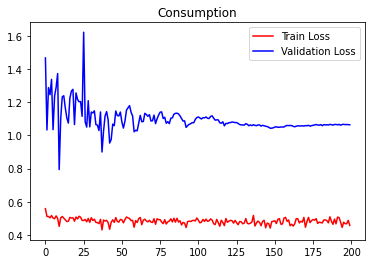

In [ ]:
plt.plot(train_losses, 'r', label='Train Loss')
plt.plot(valid_losses, 'b', label='Validation Loss')
plt.legend()
plt.title('Consumption')
plt.show()

# print(len(preds))
# print(len(targets))

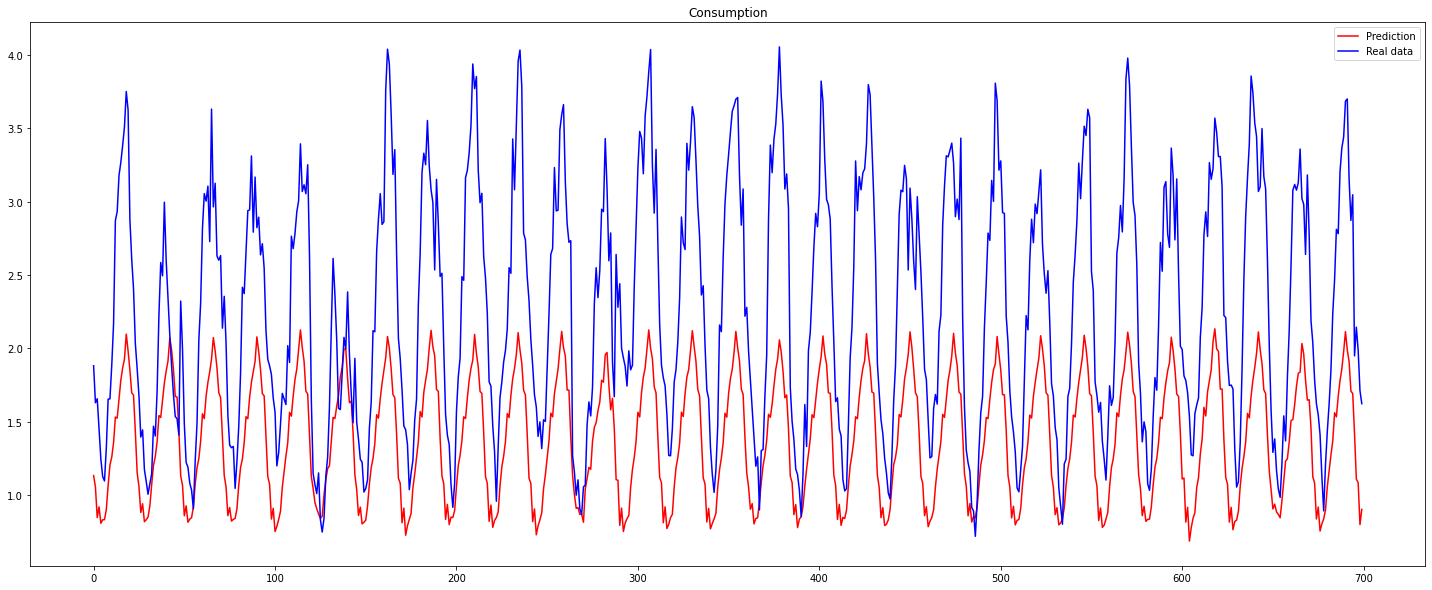

In [ ]:
p, t=[], []
for i in range(len(preds)):
    for j in range(len(preds[0])):
        p.append(preds[i][j])
        t.append(targets[i][j])
plt.figure(figsize=(25,10))
plt.plot([(i*consumption_std)+consumption_mean for i in p[:700]],'r',label='Prediction')
plt.plot([(i*consumption_std)+consumption_mean for i in t[:700]],'b',label='Real data')
plt.legend()
plt.title('Consumption')
plt.show()